# Titanic Prediction, with all models explains

This notebook extracts the features, performs the preprocessing steps, and applies different models. 
Each model is described, highlighting its benefits and potential drawbacks

# 0. Load libraries and input data

In [16]:
import os
import sys
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTENC

# Modelling
# Standard Machine Learning Algorithms
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

sys.path.append("../")
from utils import preprocessing_tools

print("Tensorflow version " + str(tf.__version__))

config = {
    'test_size': 0.2,
    'seed': 14,
    'balance_dataset': True
}

train_data = pd.read_csv('../input/train.csv')
train_data.head(5)

Tensorflow version 2.10.0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 1. Preprocessing steps
This section includes:
- Feature extraction
- Preprocessing using Pipelines, including
    - Fix categorical missing values with rules
    - One-hot encoding
    - Fix missing values with Imputer
    - Feature scaling
    - If required, balance dataset
- Train/Test split

In [17]:
# Extract relevant features
train_data = preprocessing_tools.titanic_feature_extraction(train_data)

# Fill NA from Embarked
train_data['Embarked'] = train_data.Embarked.fillna('NoBoardingRecorded')

# OneHotEncode Categories
cat_encoder = OneHotEncoder()
cat_features = ['Embarked', 'cabinLetter', 'Pclass']
all_df = [train_data]
# Perform OneHotEncoder for each feature
for cat in cat_features:
    cat_x = cat_encoder.fit_transform(train_data[[cat]])
    all_df.append(pd.DataFrame(
        cat_x.toarray(), 
        columns=cat_encoder.categories_, 
        index=train_data.index))

# Concatenate OneHotEncoder results
train_data = pd.concat(all_df, axis=1)

# Input missing values of age as the median
median_imputer = SimpleImputer(strategy='median')
train_data['Age'] = median_imputer.fit_transform(train_data[['Age']])

# Standardise the numerical values
num_scaler = StandardScaler()
num_features = ['Age', 'Fare', 'SibSp', 'Parch']
train_data[num_features] = num_scaler.fit_transform(train_data[num_features])

# Drop columns not used for prediction
clean_train_data = train_data.drop(['PassengerId', 'Name', 'Sex', 'Pclass', 'Ticket', 'Cabin', 'Embarked', 'cabinLetter'], axis=1)
clean_train_data.head()

,Survived,Age,SibSp,Parch,Fare,hasCabin,numCabins,isFemale,"(C,)","(NoBoardingRecorded,)",...,"(C,)","(D,)","(E,)","(F,)","(G,)","(No Cabin,)","(T,)","(1,)","(2,)","(3,)"
0,0,-0.565736,0.432793,-0.473674,-0.502445,0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1,0.663861,0.432793,-0.473674,0.786845,1,1.0,1,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,-0.258337,-0.474545,-0.473674,-0.488854,0,0.0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1,0.433312,0.432793,-0.473674,0.420730,1,1.0,1,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,0.433312,-0.474545,-0.473674,-0.486337,0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [18]:
# Split dataset between features and labels
y = clean_train_data.Survived
X = clean_train_data.drop(["Survived"], axis=1)
X.head()

,Age,SibSp,Parch,Fare,hasCabin,numCabins,isFemale,"(C,)","(NoBoardingRecorded,)","(Q,)",...,"(C,)","(D,)","(E,)","(F,)","(G,)","(No Cabin,)","(T,)","(1,)","(2,)","(3,)"
0,-0.565736,0.432793,-0.473674,-0.502445,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.663861,0.432793,-0.473674,0.786845,1,1.0,1,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.258337,-0.474545,-0.473674,-0.488854,0,0.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.433312,0.432793,-0.473674,0.420730,1,1.0,1,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.433312,-0.474545,-0.473674,-0.486337,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [19]:
# If requested, balance the dataset using SMOTEC
if config['balance_dataset']:
    smote_nc = SMOTENC(categorical_features=list(range(7, 23)), random_state=config['seed'])
    X, y = smote_nc.fit_resample(X, y)

/Users/miguelcachosoblechero/opt/anaconda3/envs/Kaggle/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


In [20]:
# Perform Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=config['test_size'], random_state=14)

# 2. Titanic Modelling 

In this section, I explore the different algorithm, deep-diving on how these algorithms work, the situations in which these algorithms would perform well and its drawbacks.  

In [21]:
DM_model = DummyClassifier(strategy='most_frequent')
KNN_model = KNeighborsClassifier(n_neighbors=5)
RF_model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=14)
XGB_model = XGBClassifier(n_estimators=1000, max_depth=10, random_state=14, use_label_encoder=False)

In [24]:
# Establish the baseline performance with the Dummy Classifier
Null_model = cross_validate(DM_model, X_train, y_train, cv=5, scoring=["accuracy", "roc_auc", "recall"])
Null_accuracy = sum(Null_model['test_accuracy'])/len(Null_model['test_accuracy'])
Null_recall = sum(Null_model['test_recall'])/len(Null_model['test_recall'])
Null_AUC = sum(Null_model['test_roc_auc'])/len(Null_model['test_roc_auc'])

print(f"Null Accuracy -> {Null_accuracy}")
print(f"Null Recall   -> {Null_recall}")
print(f"Null AUC      -> {Null_AUC}")

Null Accuracy -> 0.504551948051948
Null Recall   -> 1.0
Null AUC      -> 0.5


In [25]:
# Cross-Validation
cv = StratifiedKFold(n_splits=5)

# KNN Variables
knn_conf_matrix = np.zeros((2,2))
knn_accuracy = []
knn_recall = []
knn_auc = []

# Random Forest Variables
rf_conf_matrix = np.zeros((2,2))
rf_accuracy = []
rf_recall = []
rf_auc = []

# XGBoost Variables
xg_conf_matrix = np.zeros((2,2))
xg_accuracy = []
xg_recall = []
xg_auc = []

for idx_train, idx_test in cv.split(X_train, y_train):
    # Obtain the split
    X_cv, y_cv = X_train.values[idx_train], y_train.values[idx_train]

    # Train both models 
    KNN_model.fit(X_cv, y_cv)
    RF_model.fit(X_cv, y_cv)
    XGB_model.fit(X_cv, y_cv)

    # Obtain prediction dataset
    X_cv, y_cv = X_train.values[idx_test], y_train.values[idx_test]

    # Predict both models
    KNN_pred = KNN_model.predict(X_cv)
    RF_pred = RF_model.predict(X_cv)
    XGB_pred = XGB_model.predict(X_cv)

    # Store Confusion Matrix + Accuracy Score + Recall Score + AUC
    knn_conf_matrix += confusion_matrix(y_cv, KNN_pred, normalize='true')
    rf_conf_matrix += confusion_matrix(y_cv, RF_pred, normalize='true')
    xg_conf_matrix += confusion_matrix(y_cv, XGB_pred, normalize='true')

    knn_accuracy.append(accuracy_score(y_cv, KNN_pred))
    rf_accuracy.append(accuracy_score(y_cv, RF_pred))
    xg_accuracy.append(accuracy_score(y_cv, XGB_pred))
    knn_recall.append(recall_score(y_cv, KNN_pred))
    rf_recall.append(recall_score(y_cv, RF_pred))
    xg_recall.append(recall_score(y_cv, XGB_pred))
    knn_auc.append(roc_auc_score(y_cv, KNN_pred))
    rf_auc.append(roc_auc_score(y_cv, RF_pred))
    xg_auc.append(roc_auc_score(y_cv, XGB_pred))

[18:32:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

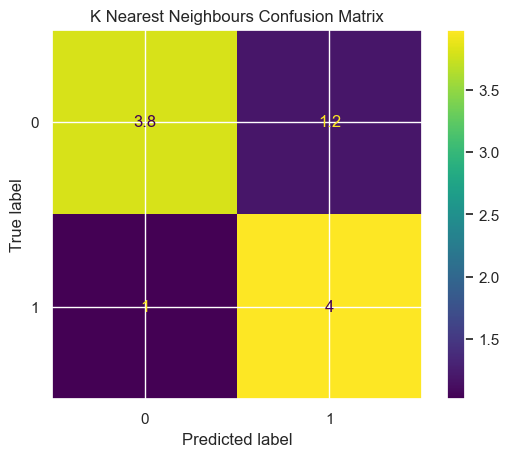

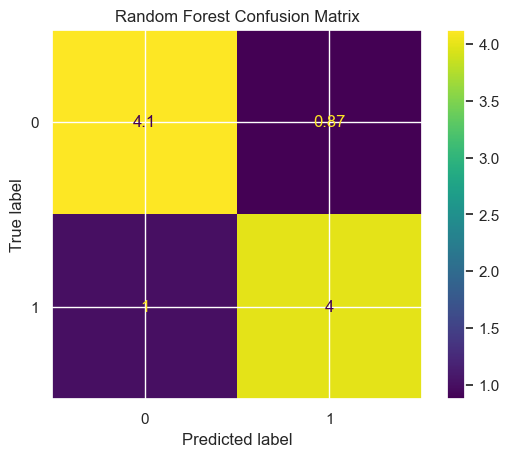

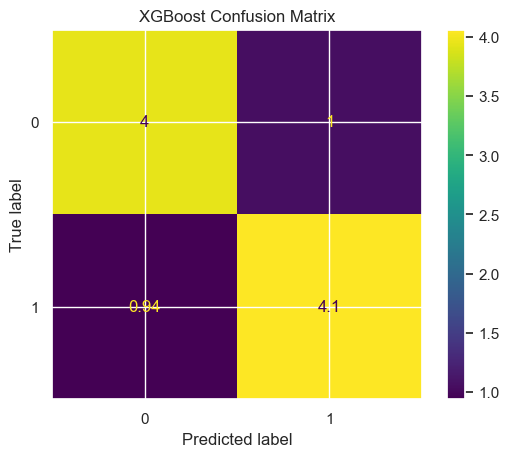

--------------
Accuracy Results
--------------
Null Hypothesis -> 0.504551948051948
KNN           -> 0.7790974025974027
Random Forest -> 0.8121038961038961
XGBoost       -> 0.8018376623376623
--------------

--------------
Recall Results
--------------
Null Hypothesis -> 1.0
KNN           -> 0.7969356486210419
Random Forest -> 0.799208375893769
XGBoost       -> 0.8128192032686414
--------------

--------------
AUC Results
--------------
Null Hypothesis -> 0.5
KNN           -> 0.7789275944254636
Random Forest -> 0.8122478661078041
XGBoost       -> 0.8018119004848956
--------------


In [26]:
# Analyse the results
# Accuracy
knn_accuracy_av = sum(knn_accuracy)/len(knn_accuracy)
rf_accuracy_av = sum(rf_accuracy)/len(rf_accuracy)
xg_accuracy_av = sum(xg_accuracy)/len(xg_accuracy)
# Recall
knn_recall_av = sum(knn_recall)/len(knn_recall)
rf_recall_av = sum(rf_recall)/len(rf_recall)
xg_recall_av = sum(xg_recall)/len(xg_recall)
# AUC 
knn_auc_av = sum(knn_auc)/len(knn_auc)
rf_auc_av = sum(rf_auc)/len(rf_auc)
xg_auc_av = sum(xg_auc)/len(xg_auc)

# Display results
# Confusion Matrix
disp = ConfusionMatrixDisplay(knn_conf_matrix)
disp.plot()
plt.title("K Nearest Neighbours Confusion Matrix")
plt.show()

disp = ConfusionMatrixDisplay(rf_conf_matrix)
disp.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

disp = ConfusionMatrixDisplay(xg_conf_matrix)
disp.plot()
plt.title("XGBoost Confusion Matrix")
plt.show()

print("--------------")
print("Accuracy Results")
print("--------------")
print("Null Hypothesis -> " + str(Null_accuracy))
print("KNN           -> " + str(knn_accuracy_av))
print("Random Forest -> " + str(rf_accuracy_av))
print("XGBoost       -> " + str(xg_accuracy_av))
print("--------------")
print("")
print("--------------")
print("Recall Results")
print("--------------")
print("Null Hypothesis -> " + str(Null_recall))
print("KNN           -> " + str(knn_recall_av))
print("Random Forest -> " + str(rf_recall_av))
print("XGBoost       -> " + str(xg_recall_av))
print("--------------")
print("")
print("--------------")
print("AUC Results")
print("--------------")
print("Null Hypothesis -> " + str(Null_AUC))
print("KNN           -> " + str(knn_auc_av))
print("Random Forest -> " + str(rf_auc_av))
print("XGBoost       -> " + str(xg_auc_av))
print("--------------")

# PENDING - Fix Confusion Matrix + Compare with NN + Fine tune parameters